# COVID-19 Research Paper K-Means Clustering

Create clusters in the data using the abstracts of each paper, using the K-means clustering algorithm.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.stem.snowball import SnowballStemmer

import re

In [2]:
"""Convert metadata.csv to a df_abstracts, which contains the sha and abstracts of every valid paper.
-read in metadata.csv to a df
-filter out rows without a full text file
-filter out rows with multiple corresponding full text files
-create df_abstracts, which contains sha and abstracts for all valid papers
"""

df = pd.read_csv("CORD-19-research-challenge/metadata.csv")
df_with_full = df.loc[df['has_full_text'] == True].drop(columns = 'has_full_text')

df_custom_license = df_with_full.loc[df_with_full['full_text_file'].str.match("custom_license")]
df_noncomm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("noncomm_use_subset")]
df_comm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("comm_use_subset")]
df_biorxiv_medrxiv = df_with_full.loc[df_with_full['full_text_file'].str.match("biorxiv_medrxiv")]

invalid_rows = []
for index, row in df_custom_license.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)

df_custom_license = df_custom_license.drop(invalid_rows)

invalid_rows = []
for index, row in df_noncomm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_noncomm_use_subset = df_noncomm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_comm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_comm_use_subset = df_comm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_biorxiv_medrxiv.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_biorxiv_medrxiv = df_biorxiv_medrxiv.drop(invalid_rows)

df_all = pd.concat([df_custom_license, df_noncomm_use_subset, df_comm_use_subset, df_biorxiv_medrxiv])

df_abstracts = df_all[['sha','abstract']]

df_abstracts.to_csv("abstracts.csv")

In [3]:
"""Take sample of rows from df_abstracts to reduce runtime"""

df_abstracts_partial = df_abstracts.sample(n=10000)
df_abstracts_partial = df_abstracts_partial.dropna()

In [4]:
"""Remove rows with bad input in abstract column"""

abstract_list = df_abstracts_partial["abstract"].values
abstract_list = [x for x in abstract_list if str(x) != 'nan']
type(abstract_list)

list

In [5]:
"""Check to make sure all abstract values are strings"""

bad_inputs = 0
for i in abstract_list:
    if type(i) != str:
        bad_inputs += 1
bad_inputs

0

In [6]:
""" Takes in abstract_list, returns abstract_list_stemmed, which contains the same list
of strings but with each word converted to reduce variability
"""

snowBallStemmer = SnowballStemmer("english")

abstract_list_stemmed = []

# adapted from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [snowBallStemmer.stem(word) for word in words]
    return words

for i in abstract_list:
    words_list = stemming_tokenizer(i)
    words_paragraph = ""
    for j in words_list:
        words_paragraph = words_paragraph + " " + j
    abstract_list_stemmed.append(words_paragraph)

In [7]:
"""Creares a df of TFIDF vectorized abstracts

TF-IDF (term frequency-inverse document frequency) is a statistical
measure that evaluates how relevant a word is to a document in a collection.

adapted from https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

token_pattern=r'(?u)\b[A-Za-z]+\b' filters out non-alphabetical characters
"""

vectorizer = TfidfVectorizer(min_df = 10, max_df = 0.9, max_features = 150, stop_words = 'english', token_pattern=r'(?u)\b[A-Za-z]+\b')
vectors = vectorizer.fit_transform(abstract_list_stemmed)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [8]:
df.drop(["abstract"], axis=1)

,acid,activ,acut,addit,age,analysi,anim,antibodi,antigen,antivir,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.0,0.000000,0.065374,0.000000,0.155454,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.064103,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.137307
1,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.109503,0.114166,0.000000,0.239925,...,0.000000,0.000000,0.00000,0.0,0.000000,0.060538,0.000000,0.000000,0.059891,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.206766,0.000000,...,0.000000,0.042364,0.00000,0.0,0.000000,0.000000,0.834785,0.098878,0.025416,0.000000
3,0.0,0.139393,0.000000,0.000000,0.185143,0.00000,0.170546,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.120961,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.117325,0.13208,0.0,0.124655,0.071150,0.000000,0.182559,0.070389,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8678,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.123586,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.394004,0.182299,0.000000
8679,0.0,0.289770,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8680,0.0,0.096211,0.000000,0.109367,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.321934,0.00000,0.0,0.114016,0.065078,0.000000,0.083489,0.064381,0.000000
8681,0.0,0.277677,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.093047,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
df

,abstract,acid,activ,acut,addit,age,analysi,anim,antibodi,antigen,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.000000,0.0,0.000000,0.065374,0.000000,0.155454,0.00000,0.000000,0.000000,0.000000,...,0.064103,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.137307
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.109503,0.114166,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.060538,0.000000,0.000000,0.059891,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.206766,...,0.000000,0.042364,0.00000,0.0,0.000000,0.000000,0.834785,0.098878,0.025416,0.000000
3,0.000000,0.0,0.139393,0.000000,0.000000,0.185143,0.00000,0.170546,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.120961,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.117325,0.13208,0.0,0.124655,0.071150,0.000000,0.182559,0.070389,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8678,0.068684,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.123586,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.394004,0.182299,0.000000
8679,0.109585,0.0,0.289770,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8680,0.000000,0.0,0.096211,0.000000,0.109367,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.321934,0.00000,0.0,0.114016,0.065078,0.000000,0.083489,0.064381,0.000000
8681,0.052506,0.0,0.277677,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
"""Apply PCA to normalized TF-IDF document vectors to reduce number of dimensions to help with K-means clustering.
Used a threshold value of 0.85 to ensure the reduced dimension vectors account for 85% of the variance."""

# adapted from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components = 0.85)
standardized_values = StandardScaler().fit_transform(df.values)
principal_components = pca.fit_transform(standardized_values)
reduced_df = pd.DataFrame(data = principal_components)
reduced_df

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,3.820638,-0.982713,-0.661759,2.083944,1.238242,-1.496007,0.386800,2.343441,0.499409,0.991025,...,-0.836135,0.358368,0.854019,0.160341,-0.817900,0.598509,0.457146,0.639385,0.541748,-0.312143
1,-0.486010,-0.658975,1.149207,2.801790,1.155256,2.075359,1.019800,-2.224902,0.488837,-2.221393,...,0.359131,0.045021,0.380973,0.104196,0.540959,0.853461,0.761373,1.254833,0.444008,0.077725
2,-2.135202,0.911734,-0.877910,0.650118,-1.199196,2.502185,-1.780966,0.313871,0.822392,0.574196,...,0.038344,0.087836,-0.906827,-1.390516,-0.477327,0.295956,0.762352,0.278378,0.203273,-0.663495
3,-2.189768,4.151523,0.414658,-0.067128,-1.226252,-1.618050,1.374252,2.687030,2.095071,-1.008718,...,-1.794261,-0.293504,-1.502883,0.443522,-0.811218,0.378680,-0.447096,-0.253589,0.484834,0.634382
4,-0.640362,0.359824,-1.906570,2.427414,-1.332462,-1.782802,-1.996550,-0.824994,1.206071,0.241540,...,0.424374,0.532715,1.828676,-0.474221,0.431948,0.011135,0.734151,-0.444839,0.386252,0.901507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8678,-4.493679,0.715210,0.429514,0.203156,-1.231706,-1.693643,0.833565,1.092634,0.805569,1.639224,...,0.018265,0.480179,-0.494367,-0.346284,-0.190893,-0.147850,0.226149,0.181978,-1.061516,-0.784495
8679,-3.236146,0.783226,-0.781500,0.609439,0.026967,1.268114,-1.102431,2.226280,1.446102,0.731440,...,-0.484934,0.193403,-0.293320,-0.253148,0.971094,1.005298,-0.041266,-0.452826,0.202926,-0.581460
8680,1.751498,-0.707593,0.424476,-2.425890,-1.628016,0.566195,0.069929,-1.304292,-1.152494,-1.108768,...,0.007878,-1.280723,-0.414294,-0.889859,-0.446573,0.032122,-0.375068,-1.498604,-0.169075,-0.049124
8681,-1.490047,-1.320140,0.136036,-1.126664,2.337478,0.855397,0.808917,0.394804,-3.577393,0.861833,...,-0.573608,0.586551,-0.415084,-0.869440,-0.459665,-0.482945,1.448624,-1.327299,-0.822298,0.549463


In [11]:
"""100 most relevant features"""

(reduced_df.columns)

RangeIndex(start=0, stop=113, step=1)

sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity


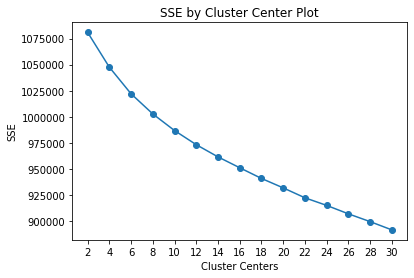

In [12]:
"""Creates an elbow plot to identify the ideal number of clusters based on sum of squared errors

copied from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
"""

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, n_init=20).fit(data).inertia_)
        print("sanity")
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(reduced_df, 30)

In [13]:
"""Displays an example of the TFIDF vector for a single paper"""

row_dict = df.loc[ 0 , : ].to_dict()

from collections import OrderedDict

dd = OrderedDict(sorted(row_dict.items(), key=lambda x: x[1], reverse=True))
dd

OrderedDict([('patient', 0.6813922150343968),
             ('n', 0.3769988680357983),
             ('risk', 0.21533476922550782),
             ('factor', 0.20174314167071625),
             ('diseas', 0.18482486068759746),
             ('clinic', 0.1794792467243466),
             ('sever', 0.15899803076470945),
             ('hospit', 0.1555128309748673),
             ('age', 0.15545445242314543),
             ('year', 0.13730738304131163),
             ('investig', 0.13136252079916572),
             ('level', 0.13014040758468257),
             ('coronavirus', 0.1251330222415917),
             ('method', 0.10976077167098927),
             ('p', 0.0783481844953236),
             ('inform', 0.0750339469540725),
             ('c', 0.07399515775577942),
             ('non', 0.07271883012120413),
             ('outbreak', 0.07214070957064564),
             ('requir', 0.07173335203185102),
             ('common', 0.07068134240188151),
             ('novel', 0.06986092643451021),
             

In [14]:
"""Adds assigned cluster cloumn to df_partial_abstracts."""

clusters = KMeans(n_clusters=14).fit_predict(df)

df_abstracts_partial["cluster"] = clusters
df_abstracts_partial.sort_values("cluster")

,sha,abstract,cluster
6281,0b5b490f075aa99ce120a49126ba2ebd1e86dba7,Abstract Immunological impairment by porcine c...,0
42135,0c12707e3172995780a54f27d7aff92e06c70a5e,Abstract Resistance to infection is the abilit...,0
14406,1812bb4edadfab1f5a4a2139bd269bb3e5a10636,Abstract Member of the dynamin family of large...,0
22394,715ec0aac4ad78092007345159945afa560b3f05,Mark Siedner and colleagues reflect on the ear...,0
8456,b88273c344747dbd8d49c80c165c2aacec3783d4,"Abstract As for most biological processes, the...",0
...,...,...,...
9758,b65e0d8d4fe0bd539a64eeb883a7b76841570080,Abstract Following infection of haplotype defi...,13
43247,f0b0fc65c05ec68cd8becdb32e5e2ee3d9ae1053,Abstract The pathogenesis of GIII.2 bovine nor...,13
21875,d2d7428869cef29308728dd3a05f0facaf1d25da,BACKGROUND: Coronavirus membrane (M) proteins ...,13
40736,5411f11bad3be63f36da71eeb6e16b09140ce199,Abstract The coronavirus nucleocapsid (N) is a...,13


In [15]:
clustercounts = df_abstracts_partial[["abstract", "cluster"]]
clustercounts = clustercounts.groupby("cluster", as_index=False).count().sort_values("cluster", ascending=True)
clustercounts

,cluster,abstract
0,0,582
1,1,780
2,2,510
3,3,367
4,4,457
5,5,351
6,6,589
7,7,2044
8,8,516
9,9,500


([<matplotlib.axis.XTick at 0x1a21629d90>,
 <a list of 14 Text xticklabel objects>)

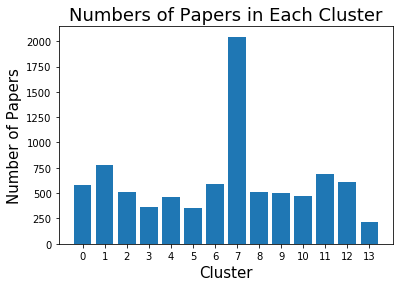

In [16]:
# plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('cluster', 'abstract', data=clustercounts)
plt.xlabel("Cluster", size=15)
plt.ylabel("Number of Papers", size=15)
plt.title("Numbers of Papers in Each Cluster", size=18)
plt.xticks(clustercounts["cluster"].values)

In [17]:
"""Use t-SNE to reduce the >100 dimensional points to two dimensions."""

from sklearn.manifold import TSNE

tsne_results = TSNE(n_components=2).fit_transform(reduced_df)

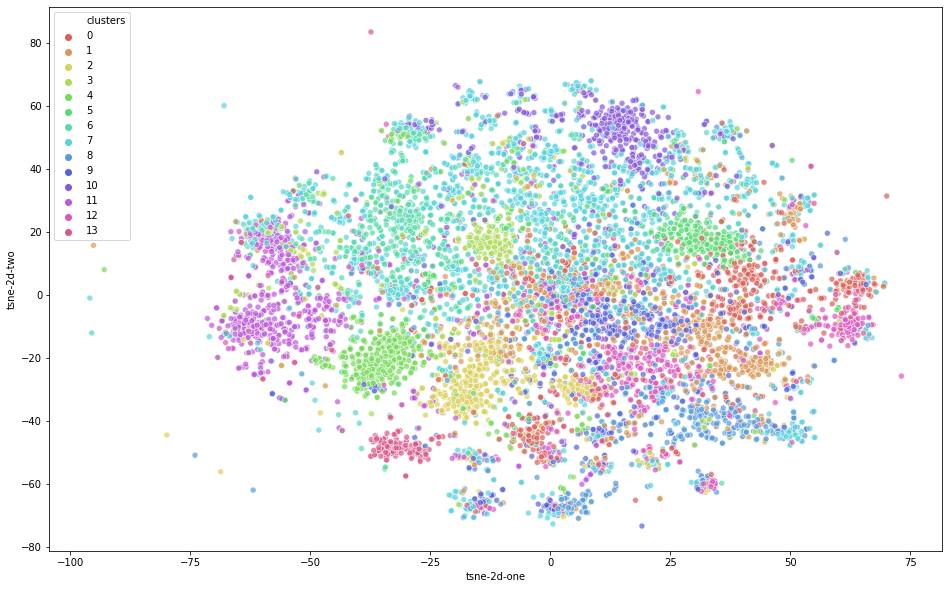

In [18]:
"""Use the results of t-SNE to visualize the clusters on a two dimensional plot."""

# adapted from https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

df_tsne = pd.DataFrame()

df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne["clusters"] = clusters

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne-2d-one',
    y='tsne-2d-two',
    data=df_tsne,
    palette=sns.color_palette("hls", 14),
    legend="full",
    alpha=0.7,
    hue="clusters"
)

In [19]:
# The sample of papers with their assigned clusters
df_abstracts_partial

,sha,abstract,cluster
40391,114ed64f52f503d9d2e2ba1fd1ee62b0a168cd84,Background: Since the outbreak of the Coronavi...,6
40852,874e540a730ee1060365af8d2caa03f537508e33,Infection by the Middle East respiratory syndr...,4
39696,661003bddb5c847237ff4a1f34a823f7971e2090,Many recombinant vector vaccines are capable o...,5
21729,3e01904917aea1c46193a3e98307e95be703c7c6,Cyclophilin A (CyPA) is a ubiquitously distrib...,9
39602,dc3d8b94ae9acb1ec585507d0d77164a7f688d10,Secondary bacterial pneumonia following influe...,3
...,...,...,...
9237,e3c2df2221f21ddbb5ece5f094fa307e26b79e9e,Abstract Signal-dependent targeting of protein...,9
41709,deea9c936b0051d487fcd8d83817ebb2905ba528,Abstract Innate immunity is involved in regula...,0
20227,0700c01d64e50ef5ae5943328bd734718cf614f4,The spread of infectious disease via commercia...,11
10806,96071f2ddd4192c50ff7bbe2c72b08f6d7210b2c,Abstract From an aqueous decoction of the trad...,8
